<a href="https://colab.research.google.com/github/MDankloff/Delayed-Fairness-Project/blob/main/Cloned_LTFpop_WP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clone from Delayed Fairness Repo

In [22]:
!git clone https://github.com/MDankloff/Delayed-Fairness-Project.git

%cd Delayed-Fairness-Project
!git pull origin main

import sys
sys.path.append('Synthetic/src')

Cloning into 'Delayed-Fairness-Project'...
remote: Enumerating objects: 1118, done.
remote: Counting objects: 100% (169/169), done.
remote: Compressing objects: 100% (105/105), done.
remote: Total 1118 (delta 116), reused 106 (delta 64), pack-reused 949 (from 1)
Receiving objects: 100% (1118/1118), 14.15 MiB | 18.31 MiB/s, done.
Resolving deltas: 100% (449/449), done.
/content/Delayed-Fairness-Project/Delayed-Fairness-Project
From https://github.com/MDankloff/Delayed-Fairness-Project
 * branch            main       -> FETCH_HEAD
Already up to date.


In [23]:
from generator import *
from evaluation import *
from fair_model import FairModel
from baselines import LR, CvxFairModel, EOFairModel
from simulator import *
from utils import combine_tuples


In [24]:
from generator import Agent
print([m for m in dir(Agent) if not m.startswith('_')])

['compute_observed_rejection_gap', 'gen_init_profile', 'gen_next_profile', 'set_eps']


In [25]:
if not hasattr(Agent, 'compute_observed_rejection_gap'):
  from generator import Agent

def compute_observed_rejection_gap(self, #agent
                                   adj, #matrix for social network
                                   D, # array for decisions at time t
                                   s, # array for protected attributes
                                   active=None, # array for indicating who is still in the system 1 means active, 0 means opted out
                                   exclude_inactive_from_denominator=True): #if true dont count for opted-out neighbouts
    """
    Compute peer spillover signal O_t for each agent.
    Looks at neighbours into two groups (in-group, outgroup)
    computes rejection rate for each group
    """
    n = len(s) #get total nr of applicants
    D = np.asarray(D, dtype=int)
    s = np.asarray(s, dtype=int)
    adj = np.asarray(adj)

    if active is None:
        active = np.ones(n, dtype=int)
    active = np.asarray(active, dtype=int)

    O = np.zeros(n, dtype=int)

    for i in range(n):
        neighbors = np.where(adj[i] > 0)[0] #find all neighbours by looking at row i of the adjacency matrix

        if len(neighbors) == 0: #if no neighbours skipp to next applicant
            continue

        if exclude_inactive_from_denominator:
            neighbors = neighbors[active[neighbors] == 1]

        if len(neighbors) == 0:
            continue

        in_group = neighbors[s[neighbors] == s[i]]
        out_group = neighbors[s[neighbors] != s[i]]

        r_in = np.mean(D[in_group] == 0) if len(in_group) > 0 else 0.0
        r_out = np.mean(D[out_group] == 0) if len(out_group) > 0 else 0.0

        O[i] = 1 if r_in > r_out else 0

    return O

# Add the method to the Agent class
Agent.compute_observed_rejection_gap = compute_observed_rejection_gap

#print("Method added successfully!")

In [26]:
from generator import Agent
print([m for m in dir(Agent) if not m.startswith('_')])

['compute_observed_rejection_gap', 'gen_init_profile', 'gen_next_profile', 'set_eps']


# Set up environment

In [27]:
# Check the function signature
from generator import gen_multi_step_profiles
import inspect
print(inspect.signature(gen_multi_step_profiles))

# Also check the Agent class
from generator import Agent
print(inspect.signature(Agent.gen_next_profile))

(model, agent, steps, noise=(0.05, 0.1), seed=2021)
(self, s, X, model)


In [28]:
bank = Bank()
agent_train = Agent(n_samples=4000, protect_ratio=0.5, eps=0.5, base=[0.2, 1.0], seed=2026)
agent_test = Agent(n_samples=1000, protect_ratio=0.5, eps=0.5, base= [0.2, 1.0], seed=2027)


#generate training data
s_train, Xs_train, Ys_train = gen_multi_step_profiles(bank, agent_train, steps=5)
s_comb, X_comb, Y_comb = combine_tuples(s_train, Xs_train, Ys_train)

#train all models
d = X_comb.shape[1]

# Train Models

## Train Baseline model (LR, linear regression)

In [29]:
lr = LR(l2_reg=1e-5)
lr.train(s_comb, X_comb, Y_comb)

## Train Hu's Fairness Model

In [30]:
fm = FairModel(n_features=d + 1, lr=5e-3, l2_reg=1e-5, sf_reg=0.119, lf_reg=0.154)
fm.train(s_train, Xs_train, Ys_train, Xs_train, Ys_train, epochs=1000, plot=False)

In [31]:
# Retrain FM iteratively (as in the notebook)
num_iters = 50
for t in range(num_iters):
    _, NXs_train, NYs_train = gen_multi_step_profiles(fm, agent_train, steps=5)
    fm.train(s_train, Xs_train, Ys_train, NXs_train, NYs_train, epochs=10, plot=False)
print("FM Retraining Done!")

FM Retraining Done!


## Train DP Model

In [32]:
d = X_comb.shape[1]
dp_model = CvxFairModel(n_features= d+ 1, l2_reg=1e-5, tao=1.565)
dp_model.train(s_comb, X_comb, Y_comb)

[Fair Model with Demographic Parity] status: optimal, loss: 0.5854


## Train EO model

In [33]:
eo_model = EOFairModel(n_features=d+2, l2_reg=1e-5, tao=1.5)
eo_model.train(s_comb, X_comb, Y_comb)


[Fair Model with Equal Oppertunity] status: optimal, loss: 0.5987


# Run Simulation

In [34]:
def run_and_evaluate(model, model_name, bank, agent, steps=5):
    s, adj, edges, Xs, Ys, Ds, Ps, Os, Us, As = run_simulation(
        decision_model=model,
        repayment_model=bank,
        agent=agent,
        steps=steps,
        enforce_demographic_mixing=True,
        k_same=8,
        k_other=2,
        directed=False,
        graph_seed=2026,
        seed=2026,
        decision_coef=0.8,
        repayment_coef=0.8,
    )

    print(f"\n{'='*60}")
    print(f"=== {model_name} ===")
    print('='*60)

    # Fairness statistics
    compute_statistics(s, Xs, Ds, model, OYs=Ys)

    # Retention rates
    print(f"\nRetention rates ({model_name}):")
    s_arr = np.array(s)
    for t in range(len(As)):
        A_t = np.array(As[t])
        overall = np.mean(A_t) * 100
        r_s0 = np.mean(A_t[s_arr == 0]) * 100
        r_s1 = np.mean(A_t[s_arr == 1]) * 100
        disparity = abs(r_s0 - r_s1)
        print(f"Step {t+1}: Retention={overall:.1f}%, R(S=0)={r_s0:.1f}%, R(S=1)={r_s1:.1f}%, Disparity={disparity:.1f}%")

    return s, Xs, Ys, Ds, As


# Run for all four models
print("\n" + "="*60)
print("RUNNING ALL SIMULATIONS")
print("="*60)

results_lr = run_and_evaluate(lr, "Baseline (LR)", bank, agent_train)
results_fm = run_and_evaluate(fm, "FM (Hu et al.)", bank, agent_train)
results_eo = run_and_evaluate(eo_model, "EO", bank, agent_train)
results_dp = run_and_evaluate(dp_model, "DP", bank, agent_train)



RUNNING ALL SIMULATIONS

=== Baseline (LR) ===
------------------------------ Step 1 - Logistic Regression ------------------------------
Acc: 73.0%
Retention: 100.0%
Short Fairness: 0.101
Long fairness: 0.077
------------------------------ Step 2 - Logistic Regression ------------------------------
Acc: 72.8%
Retention: 100.0%
Short Fairness: 0.102
Long fairness: 0.150
------------------------------ Step 3 - Logistic Regression ------------------------------
Acc: 72.8%
Retention: 100.0%
Short Fairness: 0.105
Long fairness: 0.150
------------------------------ Step 4 - Logistic Regression ------------------------------
Acc: 72.7%
Retention: 100.0%
Short Fairness: 0.106
Long fairness: 0.214
------------------------------ Step 5 - Logistic Regression ------------------------------
Acc: 73.2%
Retention: 100.0%
Short Fairness: 0.103
Long fairness: 0.259



Retention rates (Baseline (LR)):
Step 1: Retention=100.0%, R(S=0)=100.0%, R(S=1)=100.0%, Disparity=0.0%
Step 2: Retention=68.6%, R(S=0

# Create figures

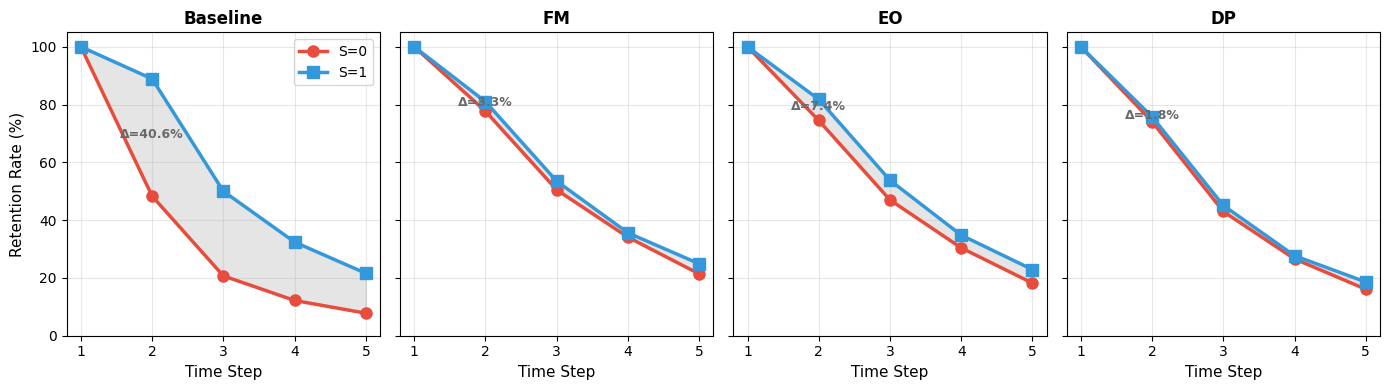

In [35]:
import matplotlib.pyplot as plt

steps = [1,2,3,4,5]

results = {
    'Baseline': {
        'S=0': [100.0, 48.3, 20.7, 12.2, 7.8],
        'S=1': [100.0, 88.9, 50.0, 32.4, 21.6],
        'disparity': [0.0, 40.6, 29.3, 20.1, 13.7],
        'long_fairness': [0.077, 0.150, 0.150, 0.214, 0.259]
    },
    'FM': {
        'S=0': [100.0, 77.7, 50.5, 34.1, 21.4],
        'S=1': [100.0, 81.0, 53.5, 35.6, 24.9],
        'disparity': [0.0, 3.3, 3.0, 1.5, 3.5],
        'long_fairness': [0.002, 0.012, 0.013, 0.051, 0.076]
    },
    'EO': {
        'S=0': [100.0, 74.5, 47.0, 30.4, 18.2],
        'S=1': [100.0, 81.8, 53.8, 34.8, 22.9],
        'disparity': [0.0, 7.4, 6.8, 4.3, 4.7],
        'long_fairness': [0.146, 0.199, 0.208, 0.304, 0.376]
    },
    'DP': {
        'S=0': [100.0, 74.1, 43.0, 26.6, 16.1],
        'S=1': [100.0, 75.8, 45.1, 27.7, 18.6],
        'disparity': [0.0, 1.8, 2.1, 1.2, 2.6],
        'long_fairness': [0.265, 0.306, 0.377, 0.583, 0.713]
    }
}

#create figure
fig, axes = plt.subplots(1, 4, figsize=(14, 4), sharey=True)

methods = ['Baseline', 'FM', 'EO', 'DP']
colors = {'S=0': '#E74C3C', 'S=1': '#3498DB'}

for idx, method in enumerate(methods):
    ax = axes[idx]

    # Plot retention rates for both groups
    ax.plot(steps, results[method]['S=0'], 'o-', color=colors['S=0'],
            label='S=0', linewidth=2.5, markersize=8)
    ax.plot(steps, results[method]['S=1'], 's-', color=colors['S=1'],
            label='S=1', linewidth=2.5, markersize=8)

    # Shade the gap between groups
    ax.fill_between(steps, results[method]['S=0'], results[method]['S=1'],
                    alpha=0.2, color='gray')

    # Add disparity annotation at step 2
    disparity_t2 = results[method]['disparity'][1]
    mid_y = (results[method]['S=0'][1] + results[method]['S=1'][1]) / 2
    ax.annotate(f'Δ={disparity_t2:.1f}%', xy=(2, mid_y), fontsize=9,
                ha='center', color='dimgray', fontweight='bold')

    ax.set_xlabel('Time Step', fontsize=11)
    if idx == 0:
        ax.set_ylabel('Retention Rate (%)', fontsize=11)
    ax.set_title(method, fontsize=12, fontweight='bold')
    ax.set_ylim(0, 105)
    ax.set_xticks(steps)
    ax.grid(True, alpha=0.3)

    if idx == 0:
        ax.legend(loc='upper right', fontsize=10)

plt.tight_layout()
plt.savefig('retention_by_group.png', dpi=300, bbox_inches='tight')
plt.savefig('retention_by_group.pdf', bbox_inches='tight')
plt.show()

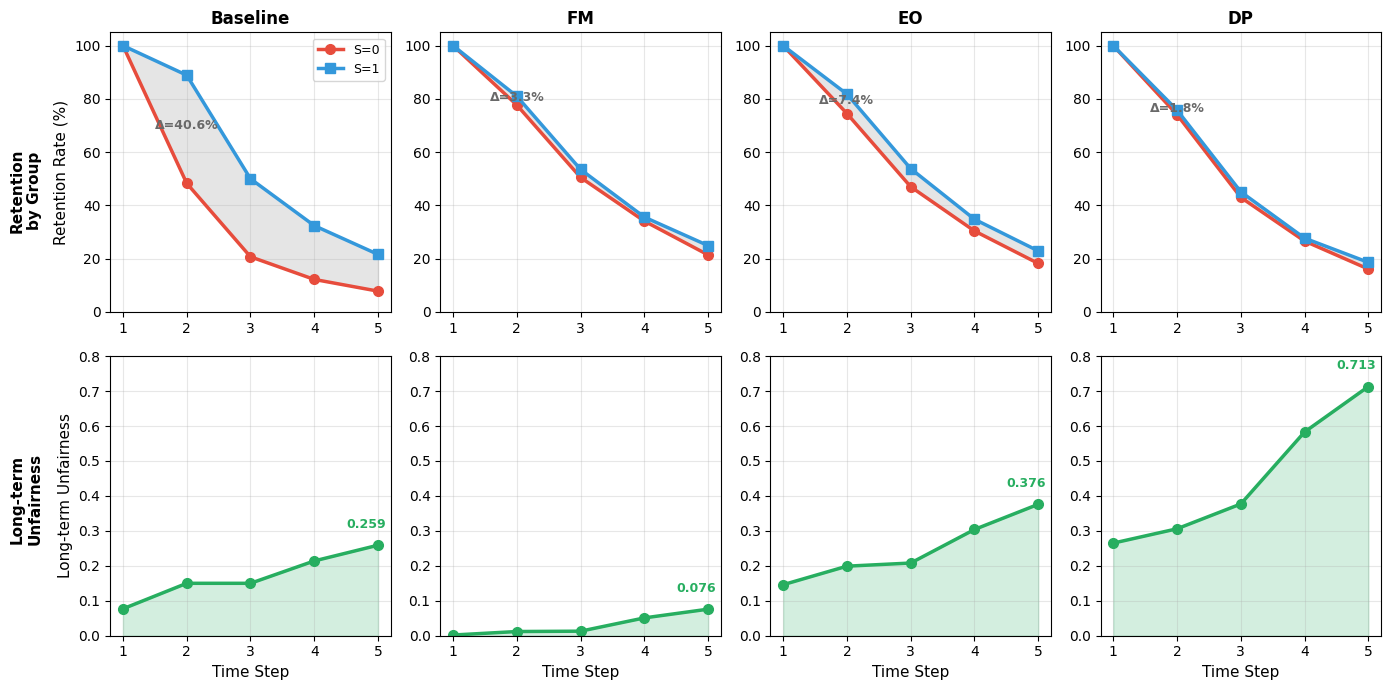

Figure saved as 'retention_and_fairness.png' and 'retention_and_fairness.pdf'


In [36]:
#long term fairness and retention

steps = [1, 2, 3, 4, 5]

results = {
    'Baseline': {
        'S=0': [100.0, 48.3, 20.7, 12.2, 7.8],
        'S=1': [100.0, 88.9, 50.0, 32.4, 21.6],
        'disparity': [0.0, 40.6, 29.3, 20.1, 13.7],
        'long_fairness': [0.077, 0.150, 0.150, 0.214, 0.259]
    },
    'FM': {
        'S=0': [100.0, 77.7, 50.5, 34.1, 21.4],
        'S=1': [100.0, 81.0, 53.5, 35.6, 24.9],
        'disparity': [0.0, 3.3, 3.0, 1.5, 3.5],
        'long_fairness': [0.002, 0.012, 0.013, 0.051, 0.076]
    },
    'EO': {
        'S=0': [100.0, 74.5, 47.0, 30.4, 18.2],
        'S=1': [100.0, 81.8, 53.8, 34.8, 22.9],
        'disparity': [0.0, 7.4, 6.8, 4.3, 4.7],
        'long_fairness': [0.146, 0.199, 0.208, 0.304, 0.376]
    },
    'DP': {
        'S=0': [100.0, 74.1, 43.0, 26.6, 16.1],
        'S=1': [100.0, 75.8, 45.1, 27.7, 18.6],
        'disparity': [0.0, 1.8, 2.1, 1.2, 2.6],
        'long_fairness': [0.265, 0.306, 0.377, 0.583, 0.713]
    }
}

# Create figure with 2 rows x 4 columns
fig, axes = plt.subplots(2, 4, figsize=(14, 7))

methods = ['Baseline', 'FM', 'EO', 'DP']
colors = {'S=0': '#E74C3C', 'S=1': '#3498DB'}
fairness_color = '#27AE60'

for idx, method in enumerate(methods):
    ax_top = axes[0, idx]
    ax_bottom = axes[1, idx]

    # ===== TOP ROW: Retention rates by group =====
    ax_top.plot(steps, results[method]['S=0'], 'o-', color=colors['S=0'],
                label='S=0', linewidth=2.5, markersize=7)
    ax_top.plot(steps, results[method]['S=1'], 's-', color=colors['S=1'],
                label='S=1', linewidth=2.5, markersize=7)

    # Shade the gap between groups
    ax_top.fill_between(steps, results[method]['S=0'], results[method]['S=1'],
                        alpha=0.2, color='gray')

    # Add disparity annotation at step 2
    disparity_t2 = results[method]['disparity'][1]
    mid_y = (results[method]['S=0'][1] + results[method]['S=1'][1]) / 2
    ax_top.annotate(f'Δ={disparity_t2:.1f}%', xy=(2, mid_y), fontsize=9,
                    ha='center', color='dimgray', fontweight='bold')

    ax_top.set_title(method, fontsize=12, fontweight='bold')
    ax_top.set_ylim(0, 105)
    ax_top.set_xticks(steps)
    ax_top.grid(True, alpha=0.3)

    if idx == 0:
        ax_top.set_ylabel('Retention Rate (%)', fontsize=11)
        ax_top.legend(loc='upper right', fontsize=9)

    # ===== BOTTOM ROW: Long-term fairness =====
    ax_bottom.plot(steps, results[method]['long_fairness'], 'o-',
                   color=fairness_color, linewidth=2.5, markersize=7)
    ax_bottom.fill_between(steps, 0, results[method]['long_fairness'],
                           alpha=0.2, color=fairness_color)

    # Add final value annotation
    final_fairness = results[method]['long_fairness'][-1]
    ax_bottom.annotate(f'{final_fairness:.3f}',
                       xy=(5, final_fairness),
                       xytext=(4.5, final_fairness + 0.05),
                       fontsize=9, color=fairness_color, fontweight='bold')

    ax_bottom.set_xlabel('Time Step', fontsize=11)
    ax_bottom.set_xticks(steps)
    ax_bottom.set_ylim(0, 0.8)
    ax_bottom.grid(True, alpha=0.3)

    if idx == 0:
        ax_bottom.set_ylabel('Long-term Unfairness', fontsize=11)

# Add row labels on the left
fig.text(0.02, 0.72, 'Retention\nby Group', ha='center', va='center',
         fontsize=11, fontweight='bold', rotation=90)
fig.text(0.02, 0.28, 'Long-term\nUnfairness', ha='center', va='center',
         fontsize=11, fontweight='bold', rotation=90)

plt.tight_layout()
plt.subplots_adjust(left=0.08)
#plt.savefig('retention_and_fairness.png', dpi=300, bbox_inches='tight')
#plt.savefig('retention_and_fairness.pdf', bbox_inches='tight')
plt.show()

#print("Figure saved as 'retention_and_fairness.png' and 'retention_and_fairness.pdf'")

## detailed metrics for signed differences and conditional fairness

In [39]:
# First, run simulations and store results for each method

def run_and_store(model, model_name, bank, agent, steps=5):
    """Run simulation and return all results."""
    s, adj, edges, Xs, Ys, Ds, Ps, Os, Us, As = run_simulation(
        decision_model=model,
        repayment_model=bank,
        agent=agent,
        steps=steps,
        enforce_demographic_mixing=True,
        k_same=8,
        k_other=2,
        directed=False,
        graph_seed=2026,
        seed=2026,
        decision_coef=0.8,
        repayment_coef=0.8,
    )
    return {
        'name': model_name,
        's': s,
        'Xs': Xs,
        'Ys': Ys,
        'Ds': Ds,
        'Ps': Ps,
        'Os': Os,
        'Us': Us,
        'As': As
    }

# Run simulations for all methods
results_baseline = run_and_store(lr, "Baseline", bank, agent_train)
results_fm = run_and_store(fm, "FM", bank, agent_train)
results_eo = run_and_store(eo_model, "EO", bank, agent_train)
results_dp = run_and_store(dp_model, "DP", bank, agent_train)

print("All simulations complete!")

All simulations complete!


In [41]:
import numpy as np

def compute_detailed_metrics(results):
    """Compute signed differences, group sizes, and representation ratios."""

    s = np.array(results['s'])
    As = results['As']
    Ds = results['Ds']

    n_s0_total = np.sum(s == 0)
    n_s1_total = np.sum(s == 1)

    print(f"\n=== {results['name']} ===")
    print("Step | N(S=0) | N(S=1) | S=0 Share | Rep. Ratio | Signed Δ(Approval)")
    print("-" * 75)

    metrics = {
        's0_share': [],
        'rep_ratio': [],
        'signed_delta': [],
        'n_s0': [],
        'n_s1': []
    }

    for t in range(len(As)):
        A_t = np.array(As[t])
        D_t = np.array(Ds[t])

        # Active counts per group
        active_s0 = np.sum((s == 0) & (A_t == 1))
        active_s1 = np.sum((s == 1) & (A_t == 1))
        total_active = active_s0 + active_s1

        # S=0 share of active population
        s0_share = active_s0 / total_active if total_active > 0 else 0

        # Retention rates
        retention_s0 = active_s0 / n_s0_total
        retention_s1 = active_s1 / n_s1_total

        # Representation ratio
        rep_ratio = retention_s0 / retention_s1 if retention_s1 > 0 else 0

        # Signed approval rate difference (among active only)
        active_mask = A_t == 1
        if active_s0 > 0 and active_s1 > 0:
            approval_s0 = np.mean(D_t[(s == 0) & active_mask])
            approval_s1 = np.mean(D_t[(s == 1) & active_mask])
            signed_delta = approval_s0 - approval_s1  # Negative = S=0 disadvantaged
        else:
            signed_delta = np.nan

        # Store metrics
        metrics['s0_share'].append(s0_share)
        metrics['rep_ratio'].append(rep_ratio)
        metrics['signed_delta'].append(signed_delta)
        metrics['n_s0'].append(active_s0)
        metrics['n_s1'].append(active_s1)

        print(f"  {t+1}  |  {active_s0:4d}  |  {active_s1:4d}  |   {s0_share:.2f}    |    {rep_ratio:.2f}    |      {signed_delta:+.3f}")

    return metrics

# Compute metrics for all methods
metrics_baseline = compute_detailed_metrics(results_baseline)
metrics_fm = compute_detailed_metrics(results_fm)
metrics_eo = compute_detailed_metrics(results_eo)
metrics_dp = compute_detailed_metrics(results_dp)


=== Baseline ===
Step | N(S=0) | N(S=1) | S=0 Share | Rep. Ratio | Signed Δ(Approval)
---------------------------------------------------------------------------
  1  |  2000  |  2000  |   0.50    |    1.00    |      -0.235
  2  |   966  |  1778  |   0.35    |    0.54    |      -0.177
  3  |   414  |  1000  |   0.29    |    0.41    |      -0.177
  4  |   245  |   648  |   0.27    |    0.38    |      -0.125
  5  |   157  |   431  |   0.27    |    0.36    |      -0.091

=== FM ===
Step | N(S=0) | N(S=1) | S=0 Share | Rep. Ratio | Signed Δ(Approval)
---------------------------------------------------------------------------
  1  |  2000  |  2000  |   0.50    |    1.00    |      -0.032
  2  |  1554  |  1620  |   0.49    |    0.96    |      -0.017
  3  |  1010  |  1071  |   0.49    |    0.94    |      -0.021
  4  |   682  |   713  |   0.49    |    0.96    |      -0.064
  5  |   429  |   499  |   0.46    |    0.86    |      -0.031

=== EO ===
Step | N(S=0) | N(S=1) | S=0 Share | Rep. Ratio 

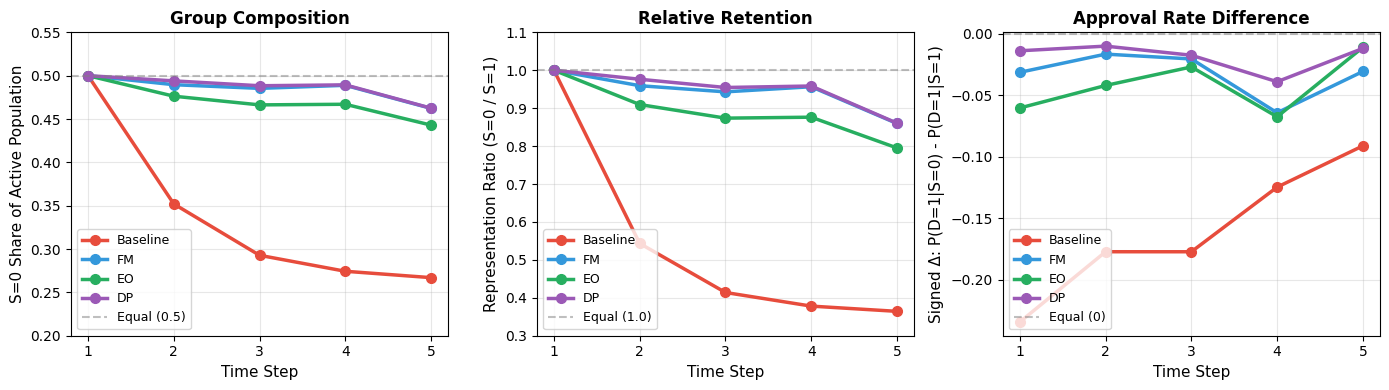

Figure saved as 'group_dynamics.png' and 'group_dynamics.pdf'


In [42]:

steps = [1, 2, 3, 4, 5]

fig, axes = plt.subplots(1, 3, figsize=(14, 4))

methods = ['Baseline', 'FM', 'EO', 'DP']
colors = {'Baseline': '#E74C3C', 'FM': '#3498DB', 'EO': '#27AE60', 'DP': '#9B59B6'}
all_metrics = {
    'Baseline': metrics_baseline,
    'FM': metrics_fm,
    'EO': metrics_eo,
    'DP': metrics_dp
}

# Plot 1: S=0 Share over time
ax = axes[0]
for method in methods:
    ax.plot(steps, all_metrics[method]['s0_share'], 'o-',
            color=colors[method], label=method, linewidth=2.5, markersize=7)
ax.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5, label='Equal (0.5)')
ax.set_xlabel('Time Step', fontsize=11)
ax.set_ylabel('S=0 Share of Active Population', fontsize=11)
ax.set_title('Group Composition', fontsize=12, fontweight='bold')
ax.set_ylim(0.2, 0.55)
ax.set_xticks(steps)
ax.legend(loc='lower left', fontsize=9)
ax.grid(True, alpha=0.3)

# Plot 2: Representation Ratio over time
ax = axes[1]
for method in methods:
    ax.plot(steps, all_metrics[method]['rep_ratio'], 'o-',
            color=colors[method], label=method, linewidth=2.5, markersize=7)
ax.axhline(y=1.0, color='gray', linestyle='--', alpha=0.5, label='Equal (1.0)')
ax.set_xlabel('Time Step', fontsize=11)
ax.set_ylabel('Representation Ratio (S=0 / S=1)', fontsize=11)
ax.set_title('Relative Retention', fontsize=12, fontweight='bold')
ax.set_ylim(0.3, 1.1)
ax.set_xticks(steps)
ax.legend(loc='lower left', fontsize=9)
ax.grid(True, alpha=0.3)

# Plot 3: Signed Approval Difference over time
ax = axes[2]
for method in methods:
    ax.plot(steps, all_metrics[method]['signed_delta'], 'o-',
            color=colors[method], label=method, linewidth=2.5, markersize=7)
ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5, label='Equal (0)')
ax.set_xlabel('Time Step', fontsize=11)
ax.set_ylabel('Signed Δ: P(D=1|S=0) - P(D=1|S=1)', fontsize=11)
ax.set_title('Approval Rate Difference', fontsize=12, fontweight='bold')
ax.set_xticks(steps)
ax.legend(loc='lower left', fontsize=9)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('group_dynamics.png', dpi=300, bbox_inches='tight')
plt.savefig('group_dynamics.pdf', bbox_inches='tight')
plt.show()

print("Figure saved as 'group_dynamics.png' and 'group_dynamics.pdf'")